GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /home/sandeep/Desktop/Windows files/HyPER-main/4_Top_results/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model           │ MPNNs          │ 14.0 K │ train │     0 │
│ 1 │ hyper           │ HyperedgeModel │  8.4 K │ train │     0 │
│ 2 │ criterion_edge  │ BCELoss        │      0 │ train │     0 │
│ 3 │ criterion_hyper │ BCELoss        │      0 │ train │     0 │
└───┴─────────────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 22.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 22.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 58                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connecto
r.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value 
of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

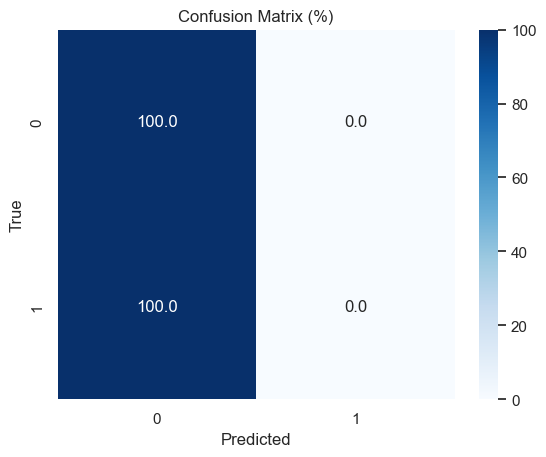

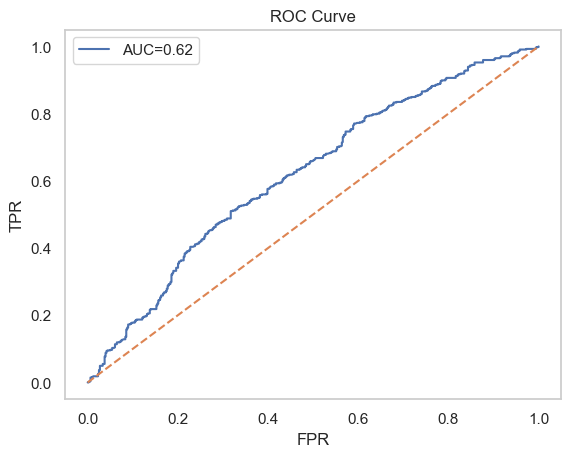

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_0.pkl

/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connecto
r.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

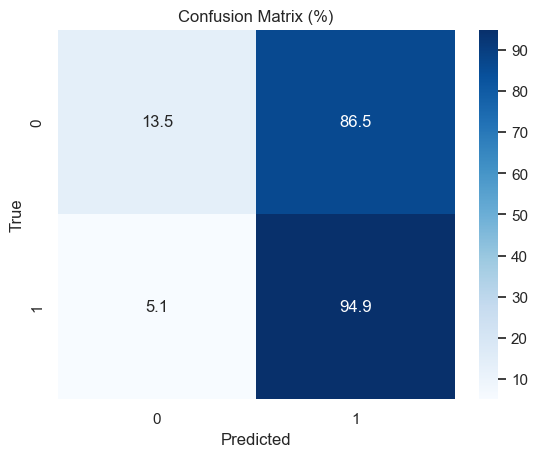

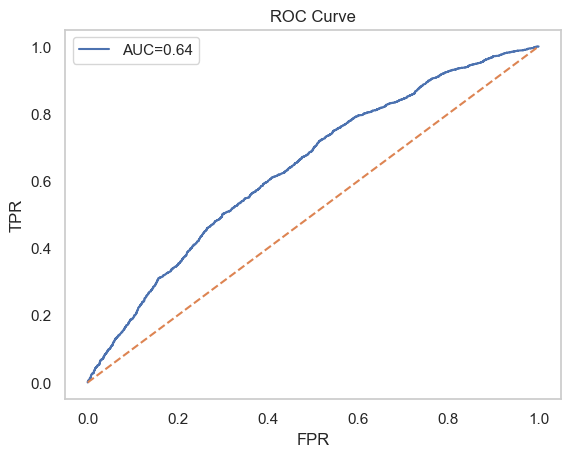

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_0.pkl

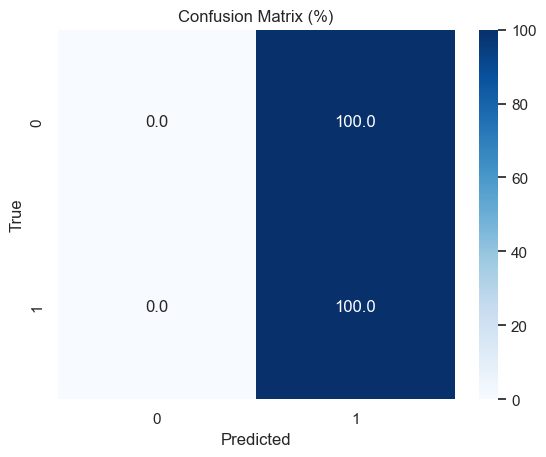

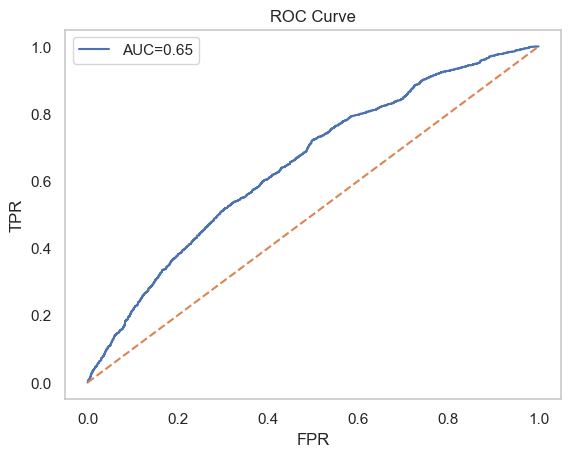

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_1.pkl

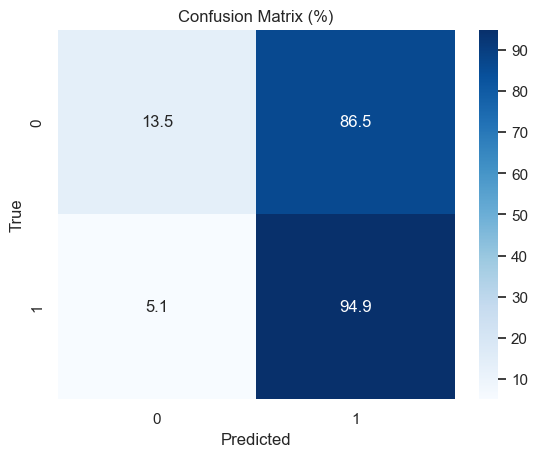

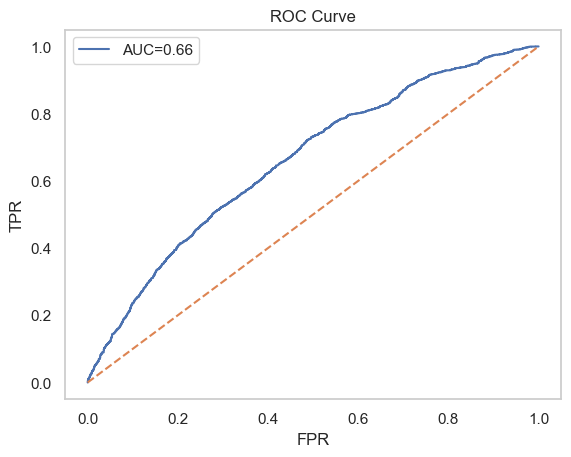

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_2.pkl

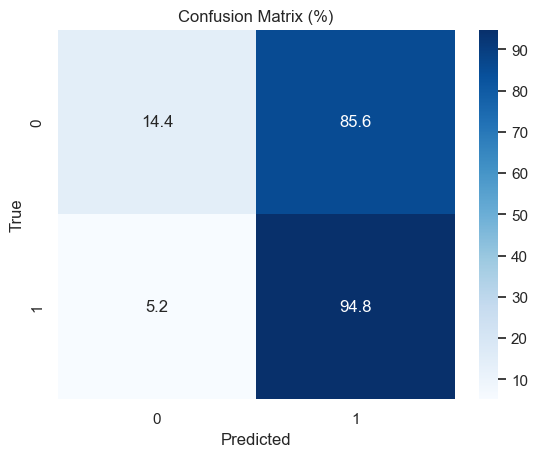

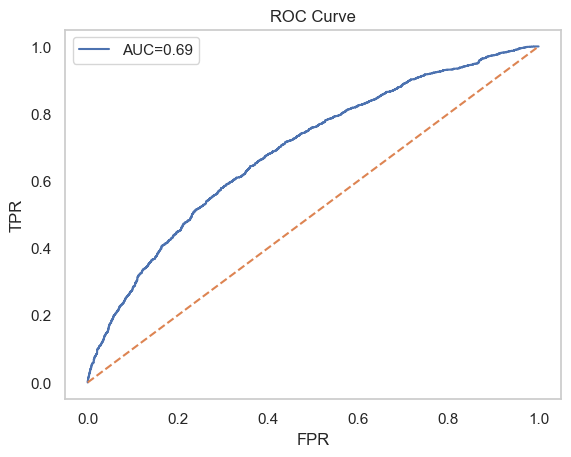

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_3.pkl

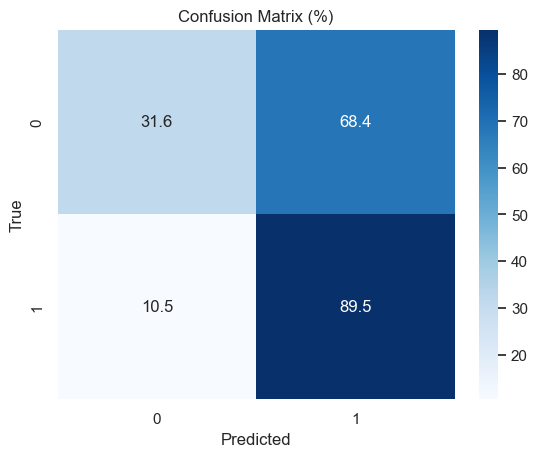

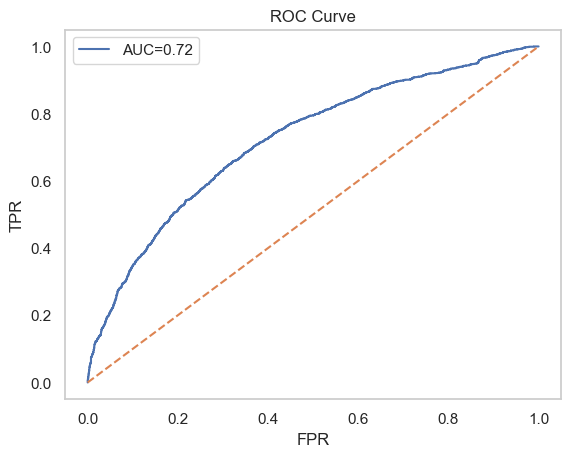

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_4.pkl

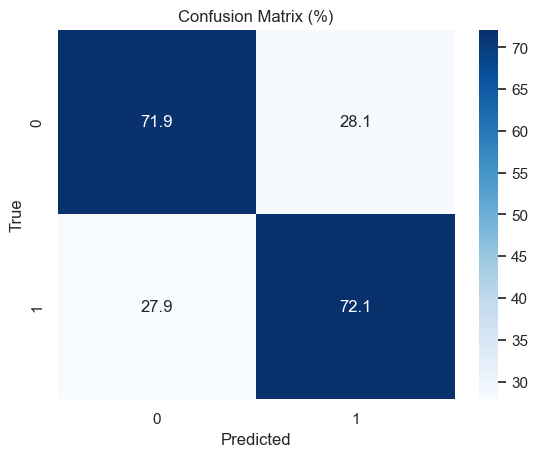

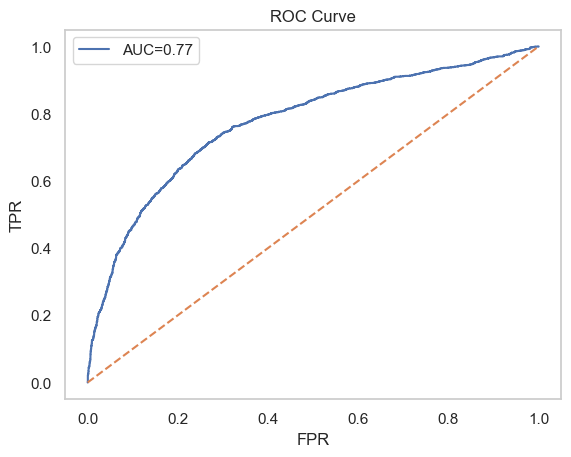

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_5.pkl

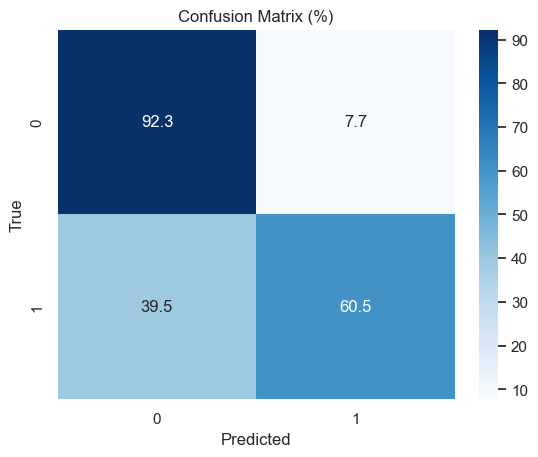

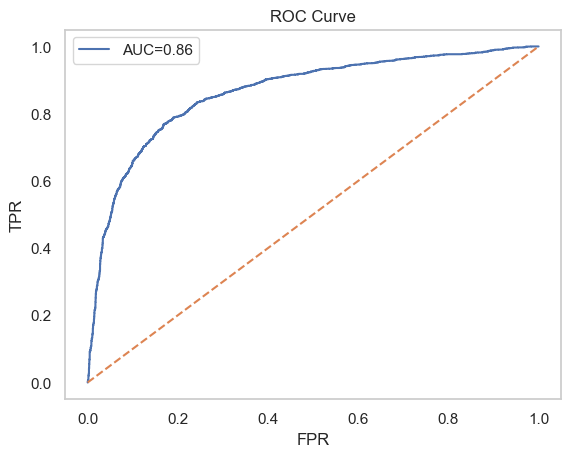

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_6.pkl

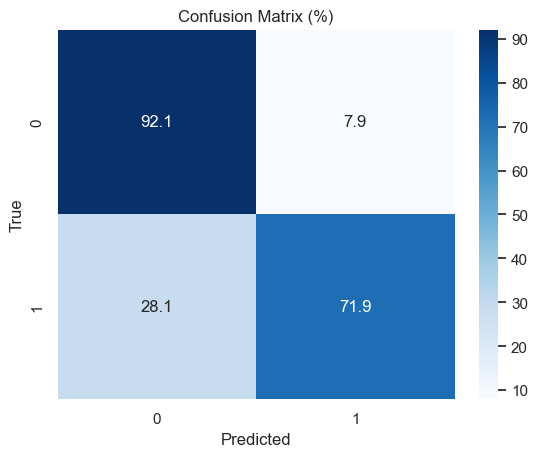

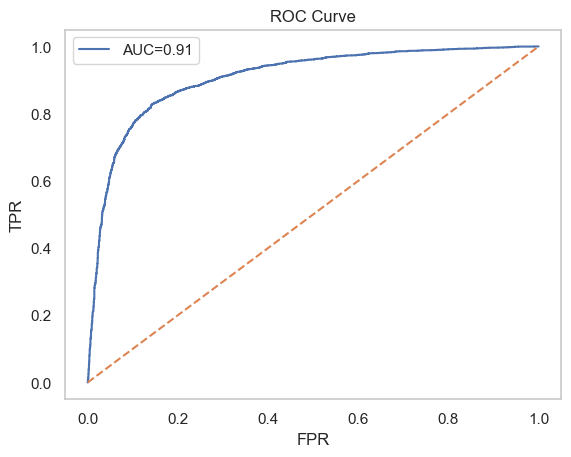

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_7.pkl

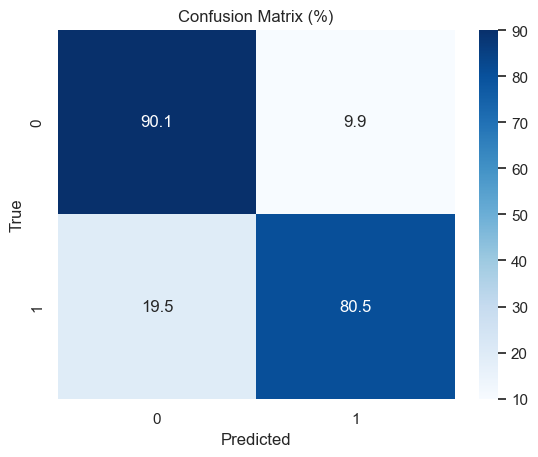

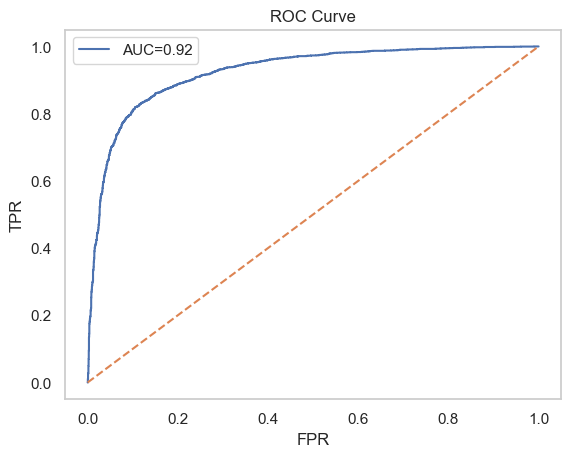

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_8.pkl

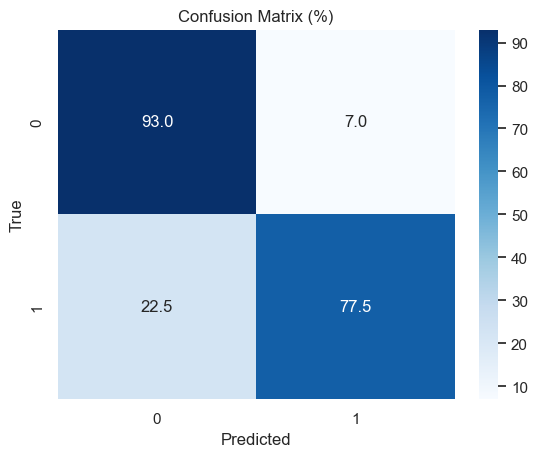

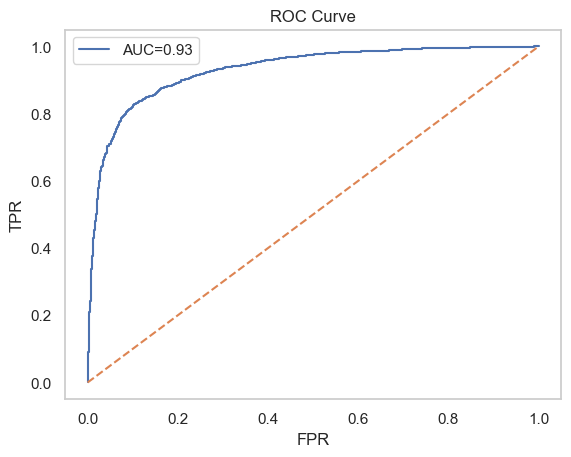

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_9.pkl

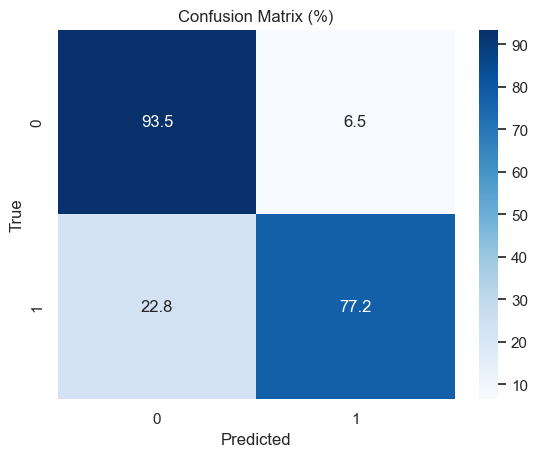

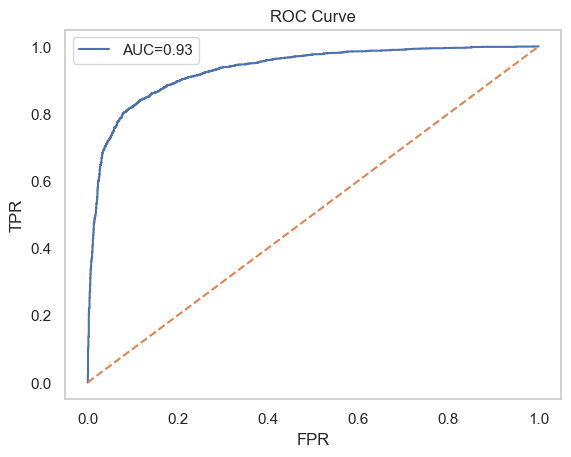

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_10.pkl

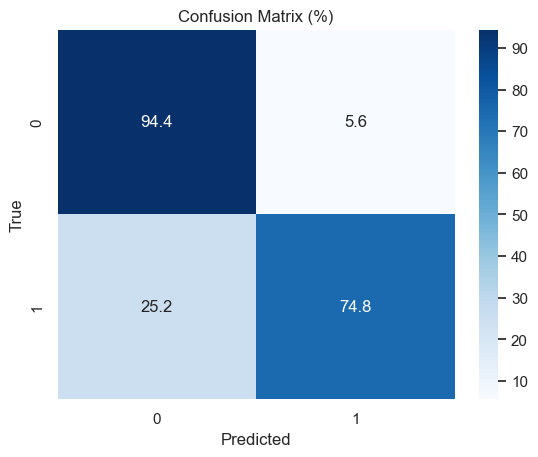

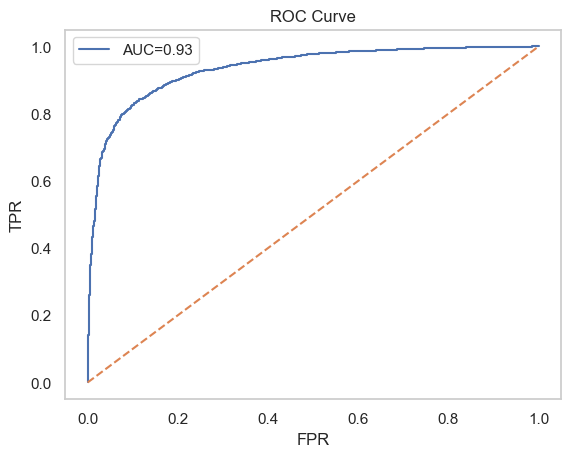

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_11.pkl

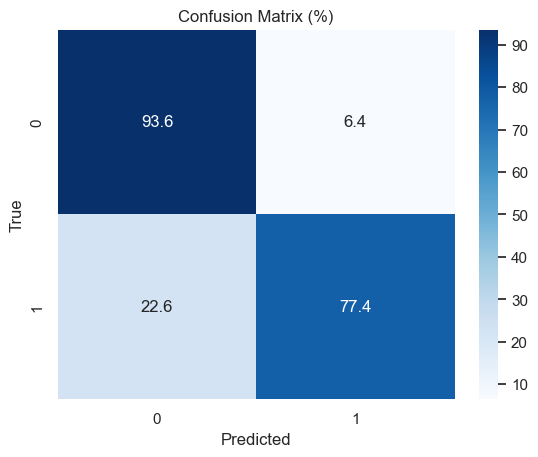

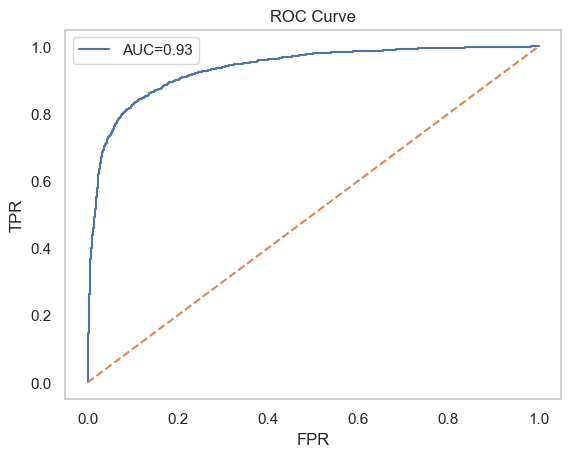

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_12.pkl

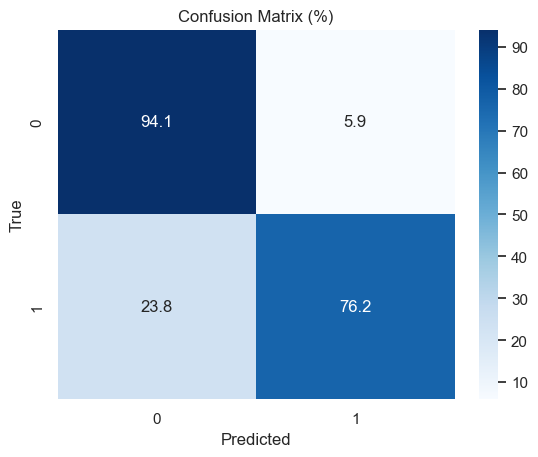

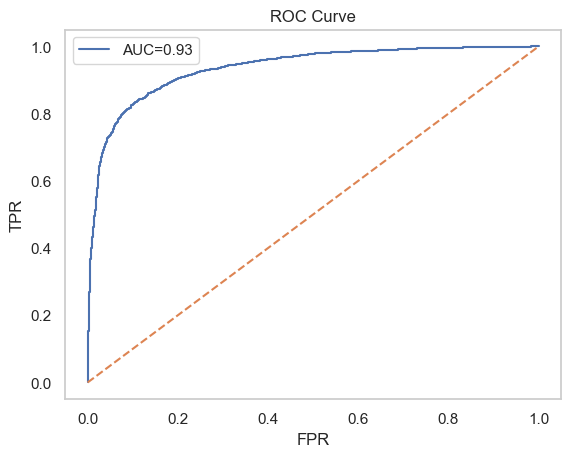

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_13.pkl

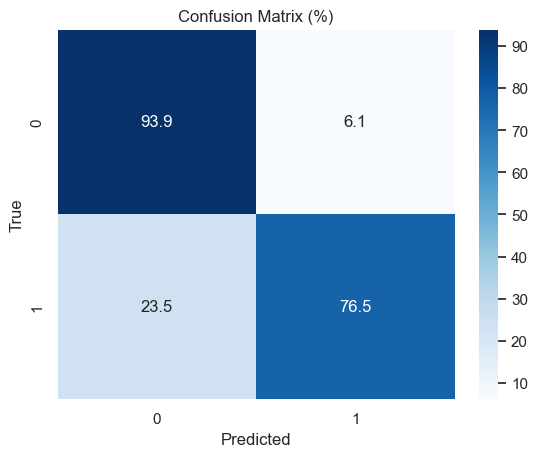

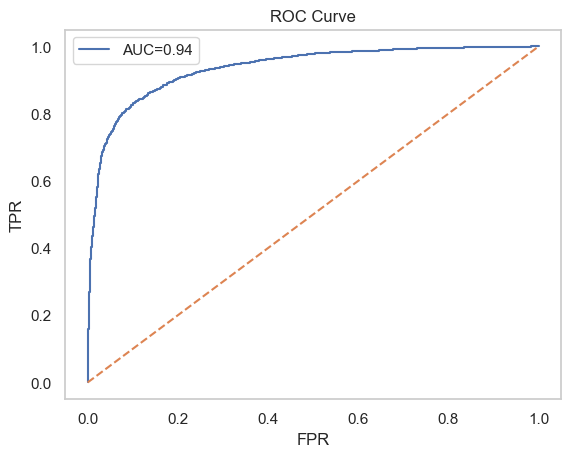

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_14.pkl

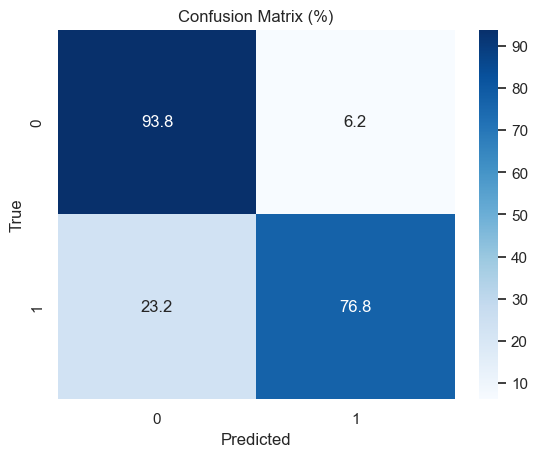

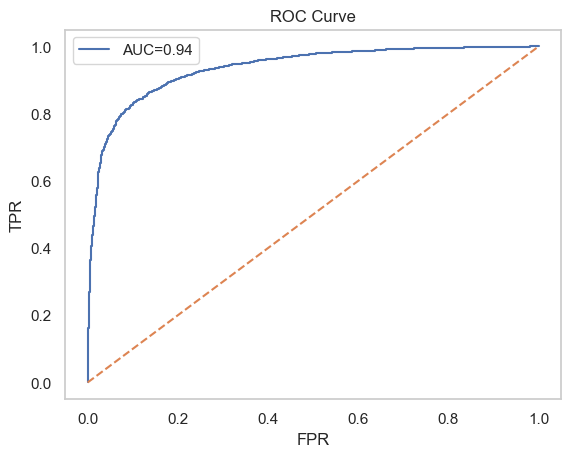

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_15.pkl

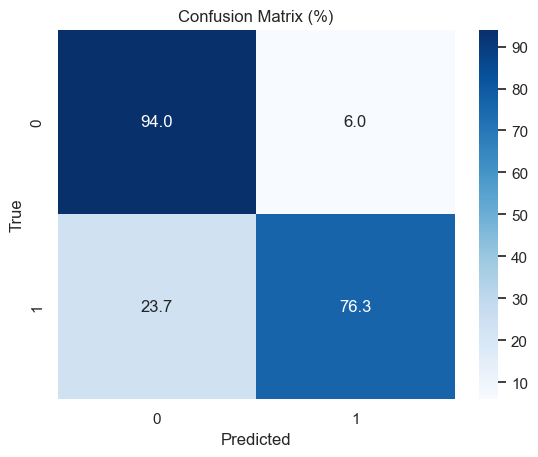

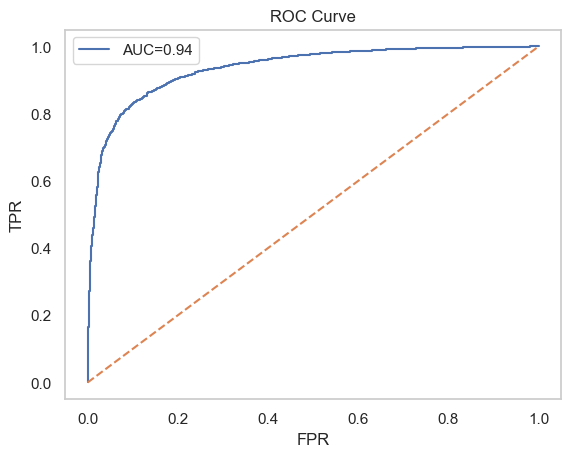

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_16.pkl

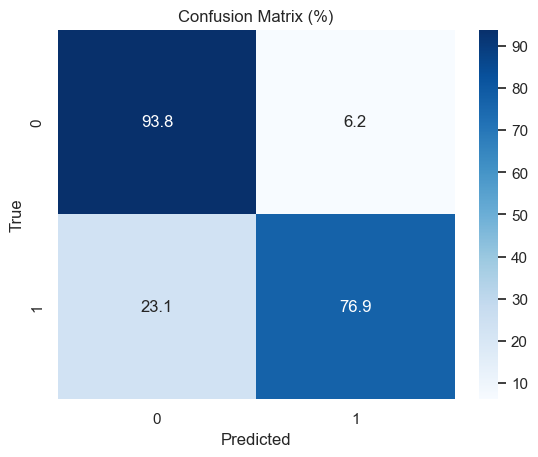

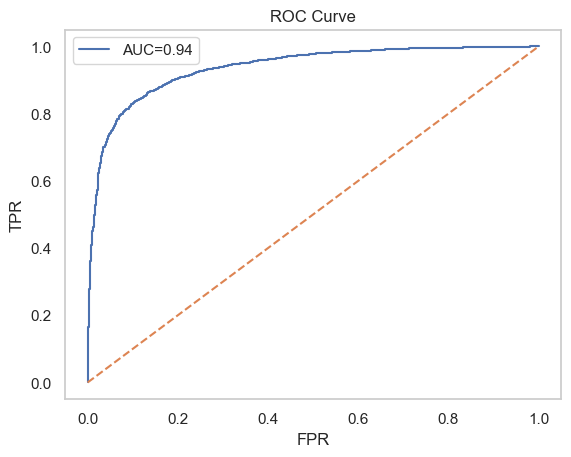

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_17.pkl

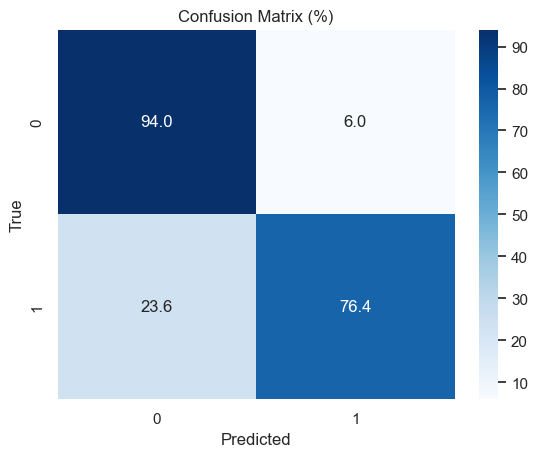

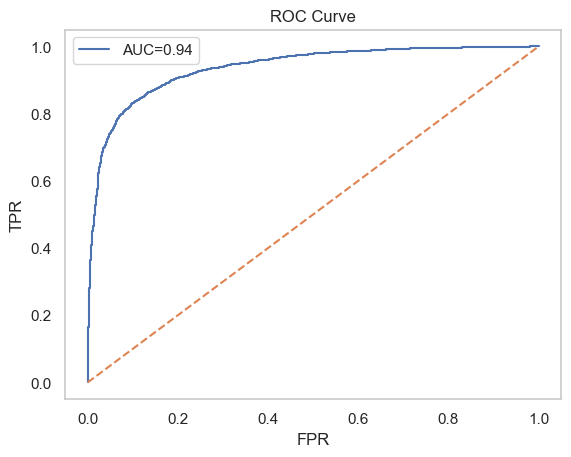

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_18.pkl

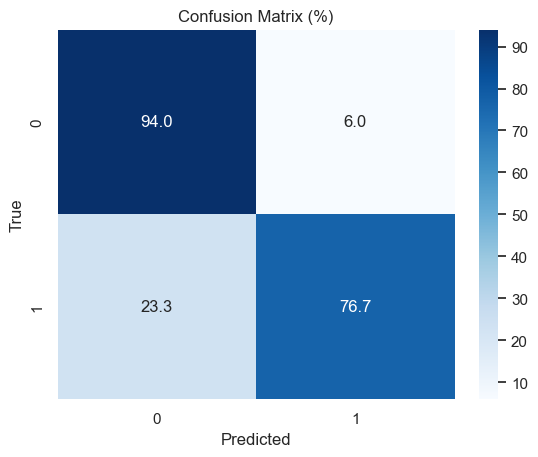

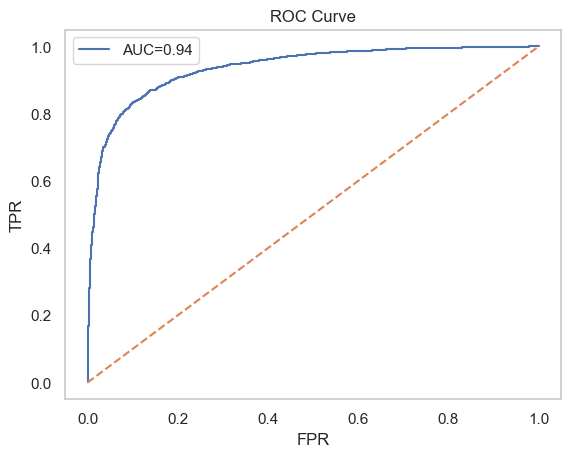

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_19.pkl

`Trainer.fit` stopped: `max_epochs=20` reached.


In [96]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import uproot
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from torch.nn import BCELoss, Sigmoid
from torch.optim import Adam
from HyPER.models import MPNNs, HyperedgeModel, EdgeLoss, CombinedLoss
import seaborn as sns
import joblib
import os
from pytorch_lightning.callbacks import ModelCheckpoint


os.makedirs("4_Top_results", exist_ok=True)

# ============================================================
# Configuration
# ============================================================
checkpoint_cb = ModelCheckpoint(
    dirpath="4_Top_results/checkpoints",
    filename="hypergraph-{epoch:02d}-{val_loss:.4f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,   # best model
    save_last=True # final model
)

jet_features = [
    'Jet.PT', 'Jet.Phi', 'Jet.Mass', 'Jet.NCharged',
    'Jet.EhadOverEem', 'Jet.Eta', 'Jet.BTag',
    'Jet.Flavor', 'Jet.T', 'Jet.DeltaEta',
    'Jet.DeltaPhi', 'Jet.ChargedEnergyFraction',
    'Jet.NeutralEnergyFraction'
]

lepton_features = [
    'Electron.PT', 'Electron.Eta', 'Electron.Phi',
    'Muon.PT', 'Muon.Eta', 'Muon.Phi'
]

met_features = ['MissingET.MET', 'MissingET.Phi']
all_features = jet_features + lepton_features + met_features

signal_file = '/home/sandeep/Desktop/Windows files/project rootfiles/13TeV_signal_5k.root'
background_file =  '/home/sandeep/Desktop/Windows files/project rootfiles/ttbarH.root'

tree_name = 'Delphes'
batch_size = 512
delta_r_threshold = 0.8

# ============================================================
# Helper functions
# ============================================================

def delta_r(eta1, phi1, eta2, phi2):
    dphi = (phi1 - phi2 + np.pi) % (2*np.pi) - np.pi
    deta = eta1 - eta2
    return np.sqrt(deta**2 + dphi**2)

def normalize_features(x):
    if x.shape[0] == 0:
        return x
    return (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)

# ============================================================
# Data conversion
# ============================================================

def convert_to_hyper_data(x_all, eta_all, phi_all, label):
    N = x_all.shape[0]
    if N < 2:
        return None

    edge_index, edge_attr, edge_target = [], [], []

    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            dr = delta_r(eta_all[i], phi_all[i], eta_all[j], phi_all[j])
            edge_index.append([i, j])
            edge_attr.append([dr])
            edge_target.append(1 if dr < delta_r_threshold else 0)

    edge_index = torch.tensor(edge_index).T
    edge_attr_s = torch.tensor(edge_attr, dtype=torch.float)
    edge_attr_t = torch.tensor(edge_target, dtype=torch.float).view(-1, 1)

    hyperedges = []
    for j in range(N):
        members = [j]
        for k in range(N):
            if j != k and delta_r(eta_all[j], phi_all[j], eta_all[k], phi_all[k]) < delta_r_threshold:
                members.append(k)
        if len(members) > 1:
            hyperedges.append(members)

    if not hyperedges:
        return None

    node_ids = np.concatenate(hyperedges)
    hedge_ids = np.repeat(np.arange(len(hyperedges)), [len(h) for h in hyperedges])
    edge_index_h = torch.tensor(np.stack([node_ids, hedge_ids]), dtype=torch.long)

    u_s = torch.tensor([[x_all[:, 0].sum(), x_all[:, 1].mean()]], dtype=torch.float)

    return Data(
        x_s=torch.tensor(x_all, dtype=torch.float),
        edge_index=edge_index,
        edge_attr_s=edge_attr_s,
        edge_attr_s_batch=torch.zeros(edge_index.shape[1], dtype=torch.long),
        edge_attr_t=edge_attr_t,
        edge_index_h=edge_index_h,
        edge_index_h_batch=torch.zeros(edge_index_h.shape[1], dtype=torch.long),
        u_s=u_s,
        x_t=torch.tensor([label], dtype=torch.float),
        batch=torch.zeros(N, dtype=torch.long)
    )

def load_data(file_path, label):
    tree = uproot.open(file_path)[tree_name]
    events = tree.arrays(all_features, library='np')
    data_list = []

    for i in range(len(events[jet_features[0]])):
        # x_jets = normalize_features(np.column_stack([events[f][i] for f in jet_features]))
        x_jets_raw = np.column_stack([events[f][i] for f in jet_features])  # RAW (GeV etc.)
        x_jets_raw = np.nan_to_num(x_jets_raw)
        n_jets = x_jets_raw.shape[0]


        x_jets = normalize_features(x_jets_raw.copy())
        # --------------------
        # Leptons (pad to 13)
        # --------------------
        lep_blocks = []

        # electrons
        if len(events['Electron.PT'][i]) > 0:
            e = np.column_stack([events[f][i] for f in lepton_features[:3]])
            e = np.pad(e, ((0,0),(0,13 - e.shape[1])))
            lep_blocks.append(e)

        # muons
        if len(events['Muon.PT'][i]) > 0:
            m = np.column_stack([events[f][i] for f in lepton_features[3:]])
            m = np.pad(m, ((0,0),(0,13 - m.shape[1])))
            lep_blocks.append(m)

        if lep_blocks:
            x_leptons = normalize_features(np.vstack(lep_blocks))
        else:
            x_leptons = np.empty((0,13))

        # --------------------
        # MET (pad to 13)
        # --------------------
        met = np.array([events[f][i] for f in met_features]).reshape(1,-1)
        x_met = normalize_features(np.pad(met, ((0,0),(0,13 - met.shape[1]))))


        x_all = np.vstack([x_jets, x_leptons, x_met])

        eta_all = np.concatenate([x_jets[:,5], x_leptons[:,1] if len(x_leptons) else [], x_met[:,1]])
        phi_all = np.concatenate([x_jets[:,1], x_leptons[:,2] if len(x_leptons) else [], x_met[:,0]])

        data = convert_to_hyper_data(x_all, eta_all, phi_all, label)

        if data:
            # 🔹 attach raw jet pT (only jets, not leptons/MET)
            
            data.raw_pt = torch.tensor(x_jets_raw[:, 0], dtype=torch.float) 
            data.n_jets = n_jets
            # data.raw_pt = torch.tensor(x_jets_raw[:, 0], dtype=torch.float)
            data_list.append(data)


    return data_list

# ============================================================
# Lightning Model
# ============================================================

class HyPERModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

        self.val_probs = []
        self.val_labels = []


        self.model = MPNNs(
            node_in_channels=13,
            edge_in_channels=1,
            global_in_channels=2,
            node_out_channels=32,
            edge_out_channels=1,
            global_out_channels=32,
            message_feats=32,
            dropout=0.1,
            activation=Sigmoid(),
            p_out='edge'
        )

        self.hyper = HyperedgeModel(
            node_in_channels=32,
            node_out_channels=1,
            global_in_channels=32,
            message_feats=32,
            dropout=0.1
        )

        self.criterion_edge = BCELoss(reduction='none')
        self.criterion_hyper = BCELoss()
        self.alpha = 0.5

        self.hyperedge_log = []

    def forward(self, data):
        x, edge_attr, u = self.model(
            data.x_s, data.edge_index, data.edge_attr_s, data.u_s, data.batch
        )

        # 🔴 FIXED: no illegal argument here
        x_hat, batch_hyper = self.hyper(
    x,
    u,
    data.batch,
    data.edge_index_h,
    data.edge_index_h_batch,
    3   # r = hyperedge order / neighborhood size
)


        return x_hat, batch_hyper, edge_attr

    def training_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)

        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        loss_hyper = self.criterion_hyper(
            x_event_pred.view(-1), batch.x_t.float().view(-1)
        )

        loss_edge = EdgeLoss(
            edge_attr_prime.view(-1),
            batch.edge_attr_t.view(-1),
            batch.edge_attr_s_batch,
            self.criterion_edge,
            reduction='mean'
        )

        loss = CombinedLoss(loss_edge, loss_hyper, self.alpha, 'mean')

        # 🔹 logging
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.train_losses.append(loss.detach().cpu().item())

        return loss


    def validation_step(self, batch, batch_idx):
        # -------------------------------
        # Event-level prediction (NEW)
        # -------------------------------
        x_hat, batch_hyper, _ = self.forward(batch)

        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        val_loss = self.criterion_hyper(
            x_event_pred.view(-1), batch.x_t.float().view(-1)
        )

        self.log("val_loss", val_loss, on_epoch=True, prog_bar=True)

        # store for ROC / confusion matrix
        self.val_probs.extend(x_event_pred.detach().cpu().numpy())
        self.val_labels.extend(batch.x_t.detach().cpu().numpy())

        # -------------------------------
        # Hyperedge physics logging (UNCHANGED)
        # -------------------------------
        for h in range(len(x_hat)):
            nodes = batch.edge_index_h[0][batch.edge_index_h[1] == h]
            # jets = torch.unique(nodes[nodes < len(batch.x_s)])
            n_jets = batch.n_jets[batch_hyper[h]]
            jets = torch.unique(nodes[nodes < n_jets])




            if len(jets) < 2:
                continue

            pts = batch.raw_pt[jets].cpu().numpy()
            etas = batch.x_s[jets, 5].cpu().numpy()
            phis = batch.x_s[jets, 1].cpu().numpy()

            drs = [
                delta_r(etas[i], phis[i], etas[j], phis[j])
                for i in range(len(jets))
                for j in range(i + 1, len(jets))
            ]

            event_id = int(batch_hyper[h].item())

            self.hyperedge_log.append({
                "event_id": event_id,
                "label": batch.x_t[event_id].item(),
                "hyperedge_score": x_hat[h].item(),
                "mean_dr": float(np.mean(drs)),
                "max_dr": float(np.max(drs)),
                "n_jets": len(jets),
                "jet_pts": pts.tolist()
            })



    def on_validation_epoch_end(self):
        y_true = np.array(self.val_labels)
        y_score = np.array(self.val_probs)
        y_pred = (y_score > 0.5).astype(int)

        roc = roc_auc_score(y_true, y_score)
        self.log("val_roc_auc", roc, prog_bar=True)

        # confusion matrix (percentage)
        cm = confusion_matrix(y_true, y_pred)
        cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

        plt.figure()
        sns.heatmap(cm_pct, annot=True, fmt=".1f", cmap="Blues")
        plt.title("Confusion Matrix (%)")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC={roc:.2f}")
        plt.plot([0, 1], [0, 1], "--")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid()
        plt.show()
        torch.save(
            self.state_dict(),
            f"4_Top_results/hypergraph_weights_epoch_{self.current_epoch}.pt"
        )

        # reset
        self.val_probs.clear()
        self.val_labels.clear()

        out_file = f"4_Top_results/hyperedge_physics_epoch_{self.current_epoch}.pkl"
        joblib.dump(self.hyperedge_log, out_file)

        print(f"[INFO] Saved hyperedge physics to {out_file}")

        # clear for next epoch
        self.hyperedge_log.clear()

    def configure_optimizers(self):
        opt = Adam(self.parameters(), lr=1e-3)
        sch = ReduceLROnPlateau(opt, mode='max', patience=10)
        return {"optimizer": opt, "lr_scheduler": sch, "monitor": "train_loss"}

# ============================================================
# Run
# ============================================================

signal = load_data(signal_file, 1)
background = load_data(background_file, 0)
dataset = signal + background
np.random.shuffle(dataset)

split = int(0.5 * len(dataset))
train_loader = DataLoader(dataset[:split], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset[split:], batch_size=batch_size)

# trainer = Trainer(
#     max_epochs=5,
#     logger=TensorBoardLogger("lightning_logs", name="hypergraph")
# )
trainer = Trainer(
    max_epochs=20,
    logger=TensorBoardLogger("lightning_logs", name="hypergraph"),
    callbacks=[checkpoint_cb],
    log_every_n_steps=4
)

trainer.fit(HyPERModel(), train_loader, val_loader)


In [97]:
import os
print(os.listdir("4_Top_results"))
print(os.listdir("4_Top_results/checkpoints"))


['hypergraph_weights_epoch_11.pt', 'hypergraph_weights_epoch_6.pt', 'hypergraph_weights_epoch_18.pt', 'hyperedge_physics_epoch_9.pkl', 'hypergraph_weights_epoch_5.pt', 'hypergraph_weights_epoch_13.pt', 'hypergraph_weights_epoch_9.pt', 'hyperedge_physics_epoch_11.pkl', 'hyperedge_physics_epoch_8.pkl', 'hypergraph_weights_epoch_0.pt', 'hypergraph_weights_epoch_7.pt', 'hyperedge_physics_epoch_15.pkl', 'hypergraph_weights_epoch_15.pt', 'checkpoints', 'event_analysis', 'signal_vs_background', 'hyperedge_physics_epoch_2.pkl', 'hypergraph_weights_epoch_1.pt', 'hypergraph_weights_epoch_10.pt', 'hyperedge_physics_epoch_3.pkl', 'hypergraph_weights_epoch_4.pt', 'hyperedge_physics_epoch_18.pkl', 'hypergraph_weights_epoch_17.pt', 'hypergraph_weights_epoch_3.pt', 'hypergraph_weights_epoch_16.pt', 'hypergraph_weights_epoch_8.pt', 'hyperedge_physics_epoch_12.pkl', 'hyperedge_physics_epoch_7.pkl', 'hyperedge_physics_epoch_6.pkl', 'hypergraph_weights_epoch_19.pt', 'hyperedge_physics_epoch_1.pkl', 'hyper

In [99]:
import joblib, pandas as pd

df = pd.DataFrame(
    joblib.load("4_Top_results/hyperedge_physics_epoch_18.pkl")
)

print(df.columns)
print("Total hyperedges:", len(df))
print(df.groupby("event_id").size())


Index(['event_id', 'label', 'hyperedge_score', 'mean_dr', 'max_dr', 'n_jets',
       'jet_pts'],
      dtype='object')
Total hyperedges: 27
event_id
0    27
dtype: int64


In [101]:
import pandas as pd

df = pd.DataFrame(
    joblib.load("4_Top_results/hyperedge_physics_epoch_4.pkl")
)

print(df.columns)
print("Total hyperedges:", len(df))

Index(['event_id', 'label', 'hyperedge_score', 'mean_dr', 'max_dr', 'n_jets',
       'jet_pts'],
      dtype='object')
Total hyperedges: 27


In [72]:
# import pandas as pd
# import joblib

# df = pd.DataFrame(
#     joblib.load("4_Top_results/hyperedge_physics_epoch_4.pkl")
# )

# print(df.groupby("event_id").size())


In [73]:
# import joblib
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # Load FINAL physics file
# df = pd.DataFrame(
#     joblib.load("4_Top_results/hyperedge_physics_epoch_18.pkl")
# )

# print("Total hyperedges:", len(df))
# print(df[["hyperedge_score", "mean_dr", "max_dr", "n_jets"]])

# # Sort hyperedges by importance
# evt = df.sort_values("hyperedge_score", ascending=False).reset_index(drop=True)

# # -------------------------------------------------
# # 1. Hyperedge score ranking (THIS IS THE CORE PLOT)
# # -------------------------------------------------
# plt.figure(figsize=(6,4))
# plt.bar(range(len(evt)), evt["hyperedge_score"])
# plt.xlabel("Hyperedges (sorted)")
# plt.ylabel("Hyperedge score")
# plt.title("Hyperedge scores for a single event")
# plt.grid()
# plt.show()

# # -------------------------------------------------
# # 2. ΔR vs score (geometry preference)
# # -------------------------------------------------
# plt.figure(figsize=(6,4))
# plt.scatter(evt["hyperedge_score"], evt["mean_dr"], s=70)
# plt.xlabel("Hyperedge score")
# plt.ylabel("Mean ΔR")
# plt.title("Mean ΔR vs hyperedge score (single event)")
# plt.grid()
# plt.show()

# # -------------------------------------------------
# # 3. Inspect TOP-3 hyperedges (physics table)
# # -------------------------------------------------
# top3 = evt.head(3)

# for i, row in top3.iterrows():
#     print("\n==============================")
#     print(f"Hyperedge rank  : {i+1}")
#     print(f"Score           : {row.hyperedge_score:.4f}")
#     print(f"N jets          : {row.n_jets}")
#     print(f"Mean ΔR         : {row.mean_dr:.4f}")
#     print(f"Max ΔR          : {row.max_dr:.4f}")
#     print(f"Jet pT [GeV]    : {np.round(row.jet_pts, 1)}")

# # -------------------------------------------------
# # 4. Jet pT spectrum for dominant hyperedges
# # -------------------------------------------------
# pts = np.concatenate(top3["jet_pts"].values)

# plt.figure(figsize=(6,4))
# plt.hist(pts, bins=15)
# plt.xlabel("Jet pT [GeV]")
# plt.ylabel("Counts")
# plt.title("Jet pT of top hyperedges (single event)")
# plt.grid()
# plt.show()


In [74]:
# import joblib
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import os

# # ============================================================
# # CONFIG
# # ============================================================

# PKL_PATH = "4_Top_results/hyperedge_physics_epoch_18.pkl"
# OUT_DIR = "4_Top_results/signal_vs_background"
# os.makedirs(OUT_DIR, exist_ok=True)

# # ============================================================
# # LOAD DATA
# # ============================================================

# df = pd.DataFrame(joblib.load(PKL_PATH))

# print("Columns:", df.columns.tolist())
# print("Total hyperedges:", len(df))

# # ============================================================
# # SELECT ONE SIGNAL & ONE BACKGROUND EVENT
# # ============================================================

# signal_events = df[df["label"] == 1]["event_id"].unique()
# bkg_events    = df[df["label"] == 0]["event_id"].unique()

# assert len(signal_events) > 0, "No signal event found"
# assert len(bkg_events) > 0, "No background event found"

# sig_id = signal_events[0]
# bkg_id = bkg_events[0]

# sig_evt = df[df["event_id"] == sig_id].sort_values("hyperedge_score", ascending=False)
# bkg_evt = df[df["event_id"] == bkg_id].sort_values("hyperedge_score", ascending=False)

# print(f"\nSignal event_id     : {sig_id}")
# print(f"Background event_id : {bkg_id}")

# # ============================================================
# # TABLES (IMPORTANT FOR THESIS)
# # ============================================================

# print("\nSignal event hyperedges:")
# print(sig_evt[["hyperedge_score", "mean_dr", "max_dr", "n_jets"]])

# print("\nBackground event hyperedges:")
# print(bkg_evt[["hyperedge_score", "mean_dr", "max_dr", "n_jets"]])

# # ============================================================
# # PLOT 1 — Hyperedge score comparison
# # ============================================================

# plt.figure(figsize=(7,4))
# plt.plot(sig_evt["hyperedge_score"].values, "o-", label="Signal")
# plt.plot(bkg_evt["hyperedge_score"].values, "o-", label="Background")
# plt.xlabel("Hyperedges (sorted)")
# plt.ylabel("Hyperedge score")
# plt.title("Hyperedge score comparison (event-by-event)")
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.savefig(f"{OUT_DIR}/score_comparison.png")
# plt.show()

# # ============================================================
# # PLOT 2 — Mean ΔR comparison
# # ============================================================

# plt.figure(figsize=(6,4))
# plt.scatter(sig_evt["hyperedge_score"], sig_evt["mean_dr"],
#             s=70, label="Signal")
# plt.scatter(bkg_evt["hyperedge_score"], bkg_evt["mean_dr"],
#             s=70, label="Background")
# plt.xlabel("Hyperedge score")
# plt.ylabel("Mean ΔR")
# plt.title("ΔR vs hyperedge score")
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.savefig(f"{OUT_DIR}/dr_vs_score.png")
# plt.show()

# # ============================================================
# # PLOT 3 — Jet multiplicity comparison
# # ============================================================

# plt.figure(figsize=(6,4))
# plt.scatter(sig_evt["hyperedge_score"], sig_evt["n_jets"],
#             s=70, label="Signal")
# plt.scatter(bkg_evt["hyperedge_score"], bkg_evt["n_jets"],
#             s=70, label="Background")
# plt.xlabel("Hyperedge score")
# plt.ylabel("Number of jets")
# plt.title("Jet multiplicity vs score")
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.savefig(f"{OUT_DIR}/njet_vs_score.png")
# plt.show()

# # ============================================================
# # PLOT 4 — Jet pT comparison (TOP hyperedges only)
# # ============================================================

# sig_top_pts = np.concatenate(sig_evt.head(3)["jet_pts"].values)
# bkg_top_pts = np.concatenate(bkg_evt.head(3)["jet_pts"].values)

# plt.figure(figsize=(6,4))
# plt.hist(sig_top_pts, bins=15, alpha=0.7, label="Signal")
# plt.hist(bkg_top_pts, bins=15, alpha=0.7, label="Background")
# plt.xlabel("Jet pT [GeV]")
# plt.ylabel("Counts")
# plt.title("Jet pT (Top hyperedges)")
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.savefig(f"{OUT_DIR}/jet_pt_comparison.png")
# plt.show()

# # ============================================================
# # SAVE TABLES
# # ============================================================

# sig_evt.to_csv(f"{OUT_DIR}/signal_event_{sig_id}.csv", index=False)
# bkg_evt.to_csv(f"{OUT_DIR}/background_event_{bkg_id}.csv", index=False)

# print("\nSaved event tables and plots to:", OUT_DIR)
# print("DONE.")


In [75]:
# sig_events = df[df["label"] == 1]["event_id"].unique()
# event_id = np.random.choice(sig_events)

# evt = df[df["event_id"] == event_id]
# evt = evt.sort_values("hyperedge_score", ascending=False)

# print(f"Event ID: {event_id}")
# print(evt[["hyperedge_score", "mean_dr", "max_dr", "n_jets"]])


In [102]:
import joblib
import pandas as pd
import numpy as np

# Load hyperedge physics
data = joblib.load("4_Top_results/hyperedge_physics.pkl")

df = pd.DataFrame(data)

print(df.head())
print("\nColumns:", df.columns.tolist())
print("Total hyperedges:", len(df))


FileNotFoundError: [Errno 2] No such file or directory: '4_Top_results/hyperedge_physics.pkl'

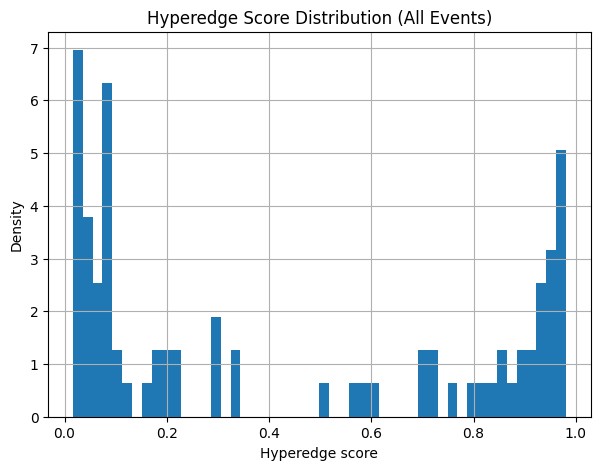

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.hist(df["hyperedge_score"], bins=50, density=True)
plt.xlabel("Hyperedge score")
plt.ylabel("Density")
plt.title("Hyperedge Score Distribution (All Events)")
plt.grid()
plt.show()


In [104]:
df_sorted = df.sort_values("hyperedge_score", ascending=False)

print(
    df_sorted.head(10)[
        ["hyperedge_score", "mean_dr", "max_dr", "n_jets", "label"]
    ]
)


    hyperedge_score   mean_dr    max_dr  n_jets  label
22         0.559303  0.455984  0.455984       2    0.0
10         0.557469  0.597006  0.597006       2    1.0
25         0.550332  0.839866  1.245736       3    0.0
6          0.548694  0.643166  0.643166       2    1.0
17         0.547111  0.713410  1.089917       4    1.0
11         0.540728  0.784680  0.989449       3    1.0
18         0.527044  1.051922  1.254312       3    1.0
5          0.524653  0.670232  0.967603       3    1.0
24         0.515358  0.652956  0.808150       3    0.0
15         0.509777  0.636031  0.662008       3    1.0


In [106]:
top5 = df_sorted.head(5)

for i, row in top5.iterrows():
    print("\n==============================")
    print(f"Score     : {row.hyperedge_score:.4f}")
    print(f"Label     : {row.label}")
    print(f"N jets    : {row.n_jets}")
    print(f"Mean ΔR   : {row.mean_dr:.3f}")
    print(f"Max ΔR    : {row.max_dr:.3f}")
    print(f"Jet pT    : {np.round(row.jet_pts, 1)}")



Score     : 0.5593
Label     : 0.0
N jets    : 2
Mean ΔR   : 0.456
Max ΔR    : 0.456
Jet pT    : [183.2  69.3]

Score     : 0.5575
Label     : 1.0
N jets    : 2
Mean ΔR   : 0.597
Max ΔR    : 0.597
Jet pT    : [107.4  63.5]

Score     : 0.5503
Label     : 0.0
N jets    : 3
Mean ΔR   : 0.840
Max ΔR    : 1.246
Jet pT    : [183.2  48.8  43.5]

Score     : 0.5487
Label     : 1.0
N jets    : 2
Mean ΔR   : 0.643
Max ΔR    : 0.643
Jet pT    : [86.4 75.4]

Score     : 0.5471
Label     : 1.0
N jets    : 4
Mean ΔR   : 0.713
Max ΔR    : 1.090
Jet pT    : [101.9  79.   61.3  61. ]


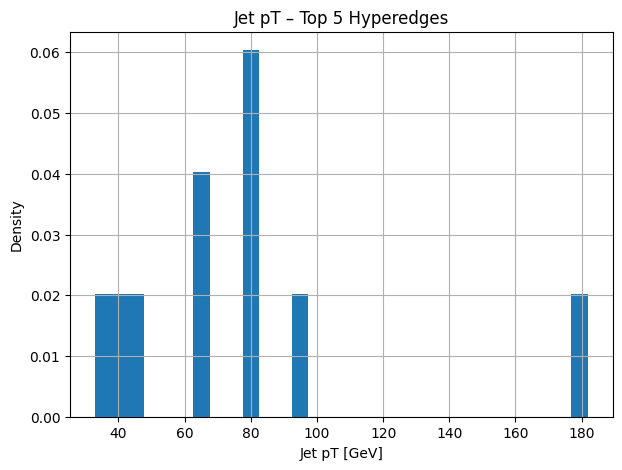

In [80]:
top5_pts = np.concatenate(top5["jet_pts"].values)

plt.figure(figsize=(7,5))
plt.hist(top5_pts, bins=30, density=True)
plt.xlabel("Jet pT [GeV]")
plt.ylabel("Density")
plt.title("Jet pT – Top 5 Hyperedges")
plt.grid()
plt.show()


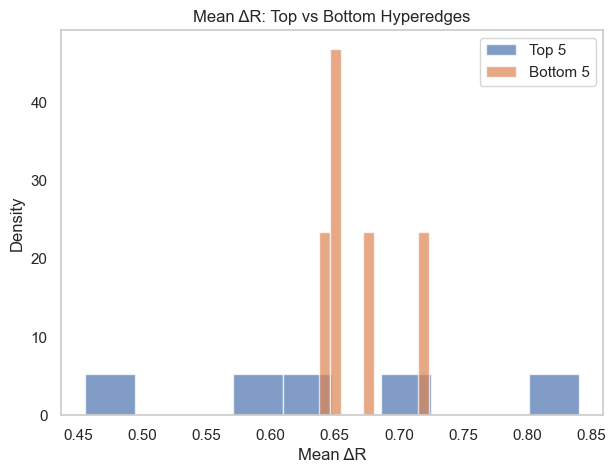

In [107]:
bottom5 = df_sorted.tail(5)

plt.figure(figsize=(7,5))
plt.hist(top5["mean_dr"], bins=10, alpha=0.7, label="Top 5", density=True)
plt.hist(bottom5["mean_dr"], bins=10, alpha=0.7, label="Bottom 5", density=True)
plt.xlabel("Mean ΔR")
plt.ylabel("Density")
plt.title("Mean ΔR: Top vs Bottom Hyperedges")
plt.legend()
plt.grid()
plt.show()


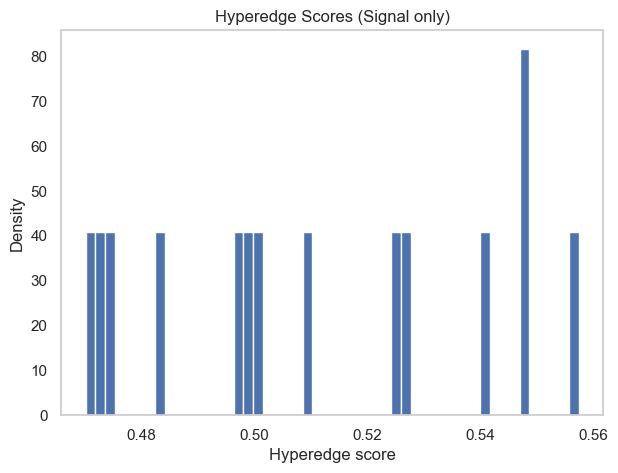

In [108]:
sig = df[df["label"] == 1]

plt.figure(figsize=(7,5))
plt.hist(sig["hyperedge_score"], bins=50, density=True)
plt.xlabel("Hyperedge score")
plt.ylabel("Density")
plt.title("Hyperedge Scores (Signal only)")
plt.grid()
plt.show()


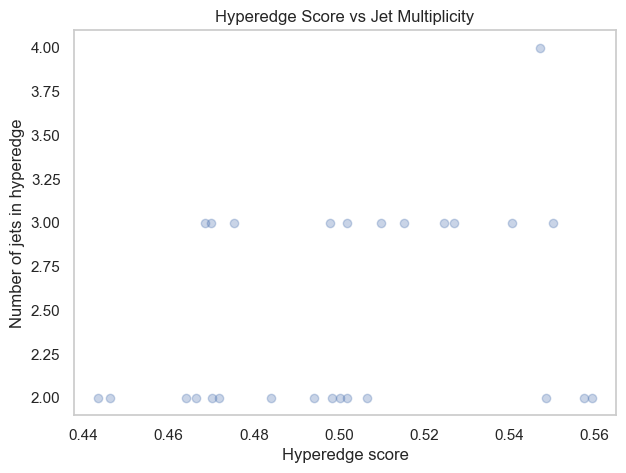

In [109]:
plt.figure(figsize=(7,5))
plt.scatter(df["hyperedge_score"], df["n_jets"], alpha=0.3)
plt.xlabel("Hyperedge score")
plt.ylabel("Number of jets in hyperedge")
plt.title("Hyperedge Score vs Jet Multiplicity")
plt.grid()
plt.show()



Loaded file: 4_Top_results/hyperedge_physics_epoch_19.pkl
Columns: ['event_id', 'label', 'hyperedge_score', 'mean_dr', 'max_dr', 'n_jets', 'jet_pts']
Total hyperedges: 27

Hyperedges per event:
event_id
0    27
dtype: int64

Signal vs background hyperedges:
label
0.0    13
1.0    14
dtype: int64

Using SIGNAL event_id = 0

Event-level table:
    hyperedge_score   mean_dr    max_dr  n_jets
6          0.985215  0.643166  0.643166       2
4          0.962391  0.399927  0.399927       2
8          0.959260  0.399927  0.399927       2
7          0.936356  0.399927  0.399927       2
5          0.912814  0.670232  0.967603       3
11         0.854429  0.784680  0.989449       3
10         0.828944  0.597006  0.597006       2
9          0.396586  0.767585  0.767585       2
3          0.369551  0.673037  0.673037       2
17         0.210209  0.713410  1.089917       4
2          0.151606  0.637765  0.637765       2
15         0.114915  0.636031  0.662008       3
16         0.102558  0.442408  

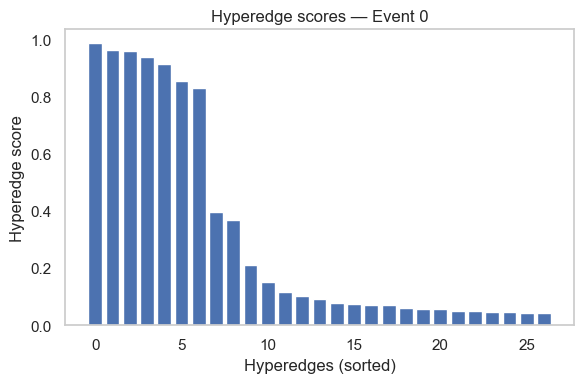

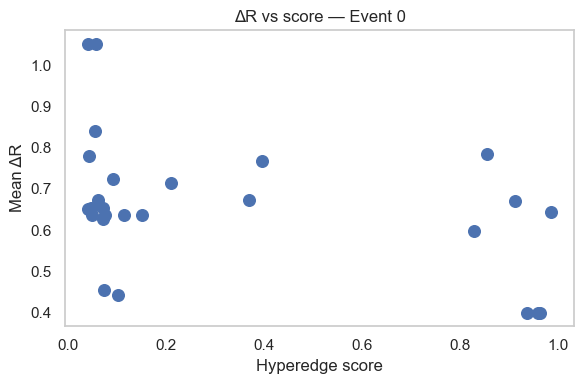


Top hyperedges (physics):

----------------------------------
Hyperedge score : 0.9852
N jets          : 2
Mean ΔR         : 0.6432
Max ΔR          : 0.6432
Jet pT [GeV]    : [86.4 75.4]

----------------------------------
Hyperedge score : 0.9624
N jets          : 2
Mean ΔR         : 0.3999
Max ΔR          : 0.3999
Jet pT [GeV]    : [576.7  86.4]

----------------------------------
Hyperedge score : 0.9593
N jets          : 2
Mean ΔR         : 0.3999
Max ΔR          : 0.3999
Jet pT [GeV]    : [576.7  86.4]

----------------------------------
Hyperedge score : 0.9364
N jets          : 2
Mean ΔR         : 0.3999
Max ΔR          : 0.3999
Jet pT [GeV]    : [576.7  86.4]

----------------------------------
Hyperedge score : 0.9128
N jets          : 3
Mean ΔR         : 0.6702
Max ΔR          : 0.9676
Jet pT [GeV]    : [576.7  86.4  75.4]

----------------------------------
Hyperedge score : 0.8544
N jets          : 3
Mean ΔR         : 0.7847
Max ΔR          : 0.9894
Jet pT [GeV]    : [144.

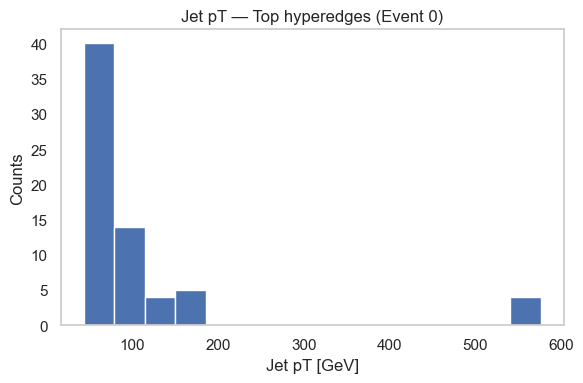


Saved event table to 4_Top_results/event_analysis/event_0_hyperedges.csv

DONE.


In [110]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ============================================================
# CONFIG
# ============================================================

PKL_PATH = "4_Top_results/hyperedge_physics_epoch_19.pkl"
OUT_DIR = "4_Top_results/event_analysis"
os.makedirs(OUT_DIR, exist_ok=True)

# ============================================================
# LOAD DATA
# ============================================================

data = joblib.load(PKL_PATH)
df["global_event_id"] = (
    df["label"].astype(int).astype(str) + "_" +
    df["event_id"].astype(int).astype(str)
)

df = pd.DataFrame(data)

print("\nLoaded file:", PKL_PATH)
print("Columns:", df.columns.tolist())
print("Total hyperedges:", len(df))

# Sanity check
required_cols = {
    "event_id", "label", "hyperedge_score",
    "mean_dr", "max_dr", "n_jets", "jet_pts"
}
assert required_cols.issubset(df.columns), "Missing required columns"

# ============================================================
# BASIC SUMMARY
# ============================================================

print("\nHyperedges per event:")
print(df.groupby("event_id").size())

print("\nSignal vs background hyperedges:")
print(df.groupby("label").size())

# ============================================================
# PICK ONE EVENT (SIGNAL IF POSSIBLE)
# ============================================================

signal_events = df[df["label"] == 1]["event_id"].unique()

if len(signal_events) > 0:
    event_id = signal_events[0]
    print(f"\nUsing SIGNAL event_id = {event_id}")
else:
    event_id = df["event_id"].iloc[0]
    print(f"\nNo signal found, using event_id = {event_id}")

evt = df[df["event_id"] == event_id].sort_values(
    "hyperedge_score", ascending=False
)

print("\nEvent-level table:")
print(evt[["hyperedge_score", "mean_dr", "max_dr", "n_jets"]])

# ============================================================
# PLOT 1 — Hyperedge scores (event-by-event)
# ============================================================

plt.figure(figsize=(6, 4))
plt.bar(range(len(evt)), evt["hyperedge_score"])
plt.xlabel("Hyperedges (sorted)")
plt.ylabel("Hyperedge score")
plt.title(f"Hyperedge scores — Event {event_id}")
plt.grid()
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/event_{event_id}_scores.png")
plt.show()

# ============================================================
# PLOT 2 — ΔR vs score (within event)
# ============================================================

plt.figure(figsize=(6, 4))
plt.scatter(evt["hyperedge_score"], evt["mean_dr"], s=70)
plt.xlabel("Hyperedge score")
plt.ylabel("Mean ΔR")
plt.title(f"ΔR vs score — Event {event_id}")
plt.grid()
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/event_{event_id}_dr_vs_score.png")
plt.show()

# ============================================================
# TOP-K HYPEREDGES (PHYSICS INSPECTION)
# ============================================================

K = len(evt)
topK = evt.head(K)

print("\nTop hyperedges (physics):")

for i, row in topK.iterrows():
    print("\n----------------------------------")
    print(f"Hyperedge score : {row.hyperedge_score:.4f}")
    print(f"N jets          : {row.n_jets}")
    print(f"Mean ΔR         : {row.mean_dr:.4f}")
    print(f"Max ΔR          : {row.max_dr:.4f}")
    print(f"Jet pT [GeV]    : {np.round(row.jet_pts, 1)}")

# ============================================================
# PLOT 3 — Jet pT spectrum (top hyperedges only)
# ============================================================

top_pts = np.concatenate(topK["jet_pts"].values)

plt.figure(figsize=(6, 4))
plt.hist(top_pts, bins=15)
plt.xlabel("Jet pT [GeV]")
plt.ylabel("Counts")
plt.title(f"Jet pT — Top hyperedges (Event {event_id})")
plt.grid()
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/event_{event_id}_jet_pt.png")
plt.show()

# ============================================================
# OPTIONAL: SAVE EVENT TABLE
# ============================================================

evt.to_csv(f"{OUT_DIR}/event_{event_id}_hyperedges.csv", index=False)
print(f"\nSaved event table to {OUT_DIR}/event_{event_id}_hyperedges.csv")

print("\nDONE.")



Loaded file: 4_Top_results/hyperedge_physics_epoch_19.pkl
Columns: ['event_id', 'label', 'hyperedge_score', 'mean_dr', 'max_dr', 'n_jets', 'jet_pts']
Total hyperedges: 27

Hyperedges per global event:
global_event_id
0_0    13
1_0    14
dtype: int64

Signal vs background hyperedges:
label
0.0    13
1.0    14
dtype: int64

Signal events: ['1_0']
Background events: ['0_0']

===== SIGNAL EVENT 1_0 =====
    hyperedge_score   mean_dr    max_dr  n_jets
6          0.985215  0.643166  0.643166       2
4          0.962391  0.399927  0.399927       2
8          0.959260  0.399927  0.399927       2
7          0.936356  0.399927  0.399927       2
5          0.912814  0.670232  0.967603       3
11         0.854429  0.784680  0.989449       3
10         0.828944  0.597006  0.597006       2
9          0.396586  0.767585  0.767585       2
17         0.210209  0.713410  1.089917       4
15         0.114915  0.636031  0.662008       3
16         0.102558  0.442408  0.442408       2
14         0.077261

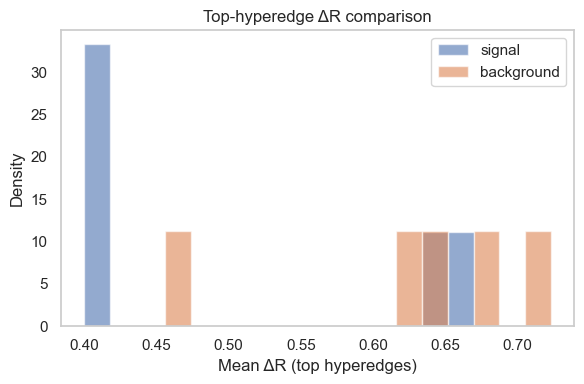

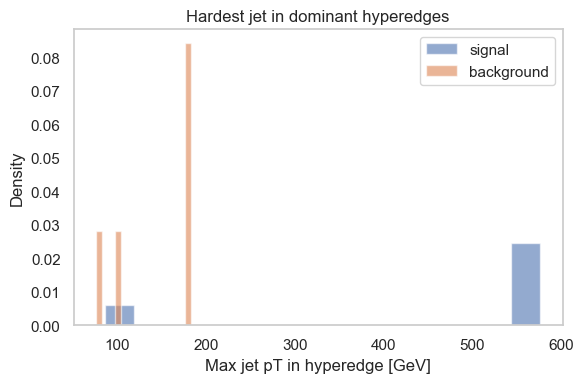


ALL DONE. Results saved in: 4_Top_results/event_analysis


In [111]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ============================================================
# CONFIG
# ============================================================

PKL_PATH = "4_Top_results/hyperedge_physics_epoch_19.pkl"
OUT_DIR = "4_Top_results/event_analysis"
os.makedirs(OUT_DIR, exist_ok=True)

N_SIGNAL_EVENTS = 3
N_BACKGROUND_EVENTS = 3
TOP_K = 5

# ============================================================
# LOAD DATA
# ============================================================

data = joblib.load(PKL_PATH)
df = pd.DataFrame(data)

print("\nLoaded file:", PKL_PATH)
print("Columns:", df.columns.tolist())
print("Total hyperedges:", len(df))

required_cols = {
    "event_id", "label", "hyperedge_score",
    "mean_dr", "max_dr", "n_jets", "jet_pts"
}
assert required_cols.issubset(df.columns), "Missing required columns"

# ============================================================
# FIX EVENT ID COLLISION (CRITICAL)
# ============================================================

df["global_event_id"] = (
    df["label"].astype(int).astype(str)
    + "_"
    + df["event_id"].astype(int).astype(str)
)

# ============================================================
# BASIC SUMMARY
# ============================================================

print("\nHyperedges per global event:")
print(df.groupby("global_event_id").size())

print("\nSignal vs background hyperedges:")
print(df.groupby("label").size())

# ============================================================
# SELECT EVENTS
# ============================================================

signal_event_ids = (
    df[df["label"] == 1]["global_event_id"]
    .drop_duplicates()
    .iloc[:N_SIGNAL_EVENTS]
    .tolist()
)

background_event_ids = (
    df[df["label"] == 0]["global_event_id"]
    .drop_duplicates()
    .iloc[:N_BACKGROUND_EVENTS]
    .tolist()
)

print("\nSignal events:", signal_event_ids)
print("Background events:", background_event_ids)

# ============================================================
# EVENT ANALYSIS FUNCTION
# ============================================================

all_top_rows = []

def analyze_event(global_event_id, label_name):
    evt = df[df["global_event_id"] == global_event_id].sort_values(
        "hyperedge_score", ascending=False
    )

    print(f"\n===== {label_name.upper()} EVENT {global_event_id} =====")
    print(evt[["hyperedge_score", "mean_dr", "max_dr", "n_jets"]])

    # ---------------- Plot 1: Hyperedge scores
    plt.figure(figsize=(6,4))
    plt.bar(range(len(evt)), evt["hyperedge_score"])
    plt.xlabel("Hyperedges (sorted)")
    plt.ylabel("Hyperedge score")
    plt.title(f"{label_name} event {global_event_id}: hyperedge scores")
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/{label_name}_{global_event_id}_scores.png")
    plt.close()

    # ---------------- Plot 2: ΔR vs score
    plt.figure(figsize=(6,4))
    plt.scatter(evt["hyperedge_score"], evt["mean_dr"], s=70)
    plt.xlabel("Hyperedge score")
    plt.ylabel("Mean ΔR")
    plt.title(f"{label_name} event {global_event_id}: ΔR vs score")
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/{label_name}_{global_event_id}_dr_vs_score.png")
    plt.close()

    # ---------------- Plot 3: Jet pT spectrum (top K)
    topK = evt.head(TOP_K)
    top_pts = np.concatenate(topK["jet_pts"].values)

    plt.figure(figsize=(6,4))
    plt.hist(top_pts, bins=15)
    plt.xlabel("Jet pT [GeV]")
    plt.ylabel("Counts")
    plt.title(f"{label_name} event {global_event_id}: jet pT (top {TOP_K})")
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/{label_name}_{global_event_id}_jet_pt.png")
    plt.close()

    # ---------------- Save CSV
    evt.to_csv(
        f"{OUT_DIR}/{label_name}_{global_event_id}_hyperedges.csv",
        index=False
    )

    # ---------------- Collect for combined plots
    for _, r in topK.iterrows():
        all_top_rows.append({
            "label": label_name,
            "global_event_id": global_event_id,
            "hyperedge_score": r.hyperedge_score,
            "mean_dr": r.mean_dr,
            "n_jets": r.n_jets,
            "max_jet_pt": max(r.jet_pts),
            "sum_jet_pt": sum(r.jet_pts)
        })

# ============================================================
# RUN ANALYSIS
# ============================================================

for gid in signal_event_ids:
    analyze_event(gid, "signal")

for gid in background_event_ids:
    analyze_event(gid, "background")

# ============================================================
# COMBINED COMPARISON PLOTS
# ============================================================

comb = pd.DataFrame(all_top_rows)

# ΔR comparison
plt.figure(figsize=(6,4))
for lbl in ["signal", "background"]:
    subset = comb[comb.label == lbl]
    plt.hist(
        subset.mean_dr,
        bins=15,
        alpha=0.6,
        density=True,
        label=lbl
    )

plt.xlabel("Mean ΔR (top hyperedges)")
plt.ylabel("Density")
plt.title("Top-hyperedge ΔR comparison")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/compare_mean_dr.png")
plt.show()

# Max jet pT comparison
plt.figure(figsize=(6,4))
for lbl in ["signal", "background"]:
    subset = comb[comb.label == lbl]
    plt.hist(
        subset.max_jet_pt,
        bins=15,
        alpha=0.6,
        density=True,
        label=lbl
    )

plt.xlabel("Max jet pT in hyperedge [GeV]")
plt.ylabel("Density")
plt.title("Hardest jet in dominant hyperedges")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/compare_max_jet_pt.png")
plt.show()

print("\nALL DONE. Results saved in:", OUT_DIR)
